In [36]:
# using %matplotlib inline to immediatly draw plot after run
%matplotlib inline 

# imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import dotenv
import datetime
import os
import pickle
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FunctionTransformer, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from abc import ABC, abstractmethod



"""prepare environment variable"""
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

True

# Get Data

In [37]:
def check_path_existance(path):
    return os.path.exists(path)

dataset_folder = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques')
train_df = None
test_df = None

if check_path_existance(dataset_folder):   
    train_df = pd.read_csv(os.path.join(dataset_folder, 'train.csv'))
    test_df = pd.read_csv(os.path.join(dataset_folder, 'test.csv'))

# Data Preprocessing Pipeline

In [38]:
class DataLoader:
    @staticmethod
    def load_data(path):
        if os.path.exists(path):
            return pd.read_csv(path)
        return None
# data
train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')

# print(DataLoader.load_data(train_data_path).shape)
# print(DataLoader.load_data(test_data_path).shape)

## Data Cleaner Class 

In [39]:
class DataCleaner:
    def __init__(self) -> None:
        # print(f"Instantiate {__class__.__name__} Class")
        pass

    def process_data(self, dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
        dataset = self.__drop_feature(dataset=dataset, columns=['Id'])
        dataset = self.__change_feature_type(dataset=dataset, mapper={'MSSubClass': str})
        dataset = self.__impute_missing_numerical_feature(dataset=dataset, dataset_type=dataset_type)
        dataset = self.__impute_missing_categorical_feature(dataset=dataset, dataset_type=dataset_type)
        return dataset
        
    def __drop_feature(self, dataset: pd.DataFrame, columns: list) -> pd.DataFrame:
        return dataset.drop(columns=columns)

    def __change_feature_type(self, dataset: pd.DataFrame, mapper: dict) -> pd.DataFrame:
        return dataset.astype(mapper) 
    
    def __impute_missing_numerical_feature(self, dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
        numerical_features = dataset.select_dtypes(include=['int', 'float']).columns.tolist()        
        if dataset_type == 'train':
            # fill missing numerical features with mean
            imputer = SimpleImputer(strategy='mean')
            dataset.loc[:, numerical_features] = imputer.fit_transform(dataset.loc[:, numerical_features])
            pickle.dump(imputer, open(os.path.join(os.path.join(project_dir, os.getenv('NUMERICAL_IMPUTER_PATH'))), "wb"))
            
        elif dataset_type == 'test':
            # fill missing numerical features with saved mean imputer
            imputer = pickle.load(open(os.path.join(os.path.join(project_dir, os.getenv('NUMERICAL_IMPUTER_PATH'))), "rb"))
            dataset.loc[:, numerical_features] = imputer.fit_transform(dataset.loc[:, numerical_features])
        else:
            print("dataset_type is neither train or test")
        return dataset

    def __impute_missing_categorical_feature(self, dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
        categorical_features = dataset.select_dtypes(include=['object']).columns.tolist()

        # fill expected missing categorical values
        categorical_features_missing_on_purpose = [
            'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 
            'PoolQC', 'Fence', 'MiscFeature'
        ]
        imputer = SimpleImputer(strategy='constant', fill_value='Missing')
        dataset.loc[:, categorical_features_missing_on_purpose] = imputer.fit_transform(dataset.loc[:, categorical_features_missing_on_purpose])

        if dataset_type == 'train':
            # fill missing categorical features with mode
            imputer = SimpleImputer(strategy='most_frequent')
            dataset.loc[:, categorical_features] = imputer.fit_transform(dataset.loc[:, categorical_features])
            pickle.dump(imputer, open(os.path.join(project_dir, os.getenv('CATEGORICAL_IMPUTER_PATH')), 'wb'))
            
        elif dataset_type == 'test':
            # fill missing categorical features with saved mode imputer
            imputer = pickle.load(open(os.path.join(os.path.join(project_dir, os.getenv('CATEGORICAL_IMPUTER_PATH'))), "rb"))
            dataset.loc[:, categorical_features] = imputer.fit_transform(dataset.loc[:, categorical_features])
        else:
            print("dataset_type is neither train or test")
        return dataset

# data_cleaner = DataCleaner()
# data_cleaner.process_data(train_df, "train")

## Data Feature Generator Class

In [40]:
class DataFeatureGenerator:
    def __init__(self) -> None:
        # print(f"Instantiate {__class__.__name__} Class")
        pass


    def process_data(self, dataset: pd.DataFrame) -> pd.DataFrame:
        # dataset = self.__generate_feature_by_sum(dataset, ['LotArea', 'LotFrontage'], 'TotalLotAre')
        dataset = self.__generate_feature_by_mean(dataset, ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], 'OverallYear')
        dataset = self.__generate_feature_by_mean(
            dataset, 
            [
                'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',	'1stFlrSF',	
                '2ndFlrSF',	'LowQualFinSF',	'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                '3SsnPorch', 'ScreenPorch'
            ], 
            'TotalSF'
        )
        dataset = self.__generate_feature_by_mean(dataset, ['GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'], 'TotalAbvGrd')
        dataset = self.__generate_feature_by_mean(dataset, ['BsmtFullBath', 'BsmtHalfBath'], 'TotalBsmtBath')
        return dataset

    def __generate_feature_by_sum(self, dataset: pd.DataFrame, features: list, new_feature_name: str) -> pd.DataFrame:
        dataset.loc[:, new_feature_name] = dataset.loc[:, features].sum(axis=1)
        return dataset 
    
    def __generate_feature_by_mean(self, dataset: pd.DataFrame, features: list, new_feature_name: str) -> pd.DataFrame:
        dataset.loc[:, new_feature_name] = dataset.loc[:, features].mean(axis=1).astype(int)
        return dataset 


# data_cleaner = DataCleaner()
# dataset = data_cleaner.process_data(train_df, "train")
# data_feature_generator = DataFeatureGenerator()
# data_feature_generator.process_data(dataset)

# Data Feature Selector

In [41]:
class DataFeatureSelector:
    def __init__(self) -> None:
        # print(f"Instantiate {__class__.__name__} Class")
        pass


    def process_data(self, dataset: pd.DataFrame, features: list) -> pd.DataFrame:
        try:
            dataset = dataset.loc[:, features]
        except Exception as e:
            print(e)
        
        return dataset 


# data_cleaner = DataCleaner()
# dataset = data_cleaner.process_data(train_df, "train")
# data_feature_generator = DataFeatureGenerator()
# dataset = data_feature_generator.process_data(dataset)
# data_feature_selector = DataFeatureSelector()
# dataset = data_feature_selector.process_data(dataset, 
#     ['OverallQual', 'MasVnrArea', 'Fireplaces', 'GarageArea', 'OverallYear', 'TotalSF', 'TotalAbvGrd', 'TotalBsmtBath'] 
#     + dataset.select_dtypes(include=['object']).columns.tolist()
# )

# Data Feature Transformer

In [43]:
class DataFeatureTransformer:
    def __init__(self) -> None:
        # print(f"Instantiate {__class__.__name__} Class")
        pass


    def process_data(self, dataset: pd.DataFrame) -> pd.DataFrame:
        dataset = self.__log_transform_feature(dataset)
        dataset = self.__ordinal_encoding(dataset)
        dataset = self.__one_hot_encoding(dataset)
        return dataset 

    def __log_transform_feature(self, dataset: pd.DataFrame) -> pd.DataFrame:
        try:
            numerical_columns = dataset.select_dtypes(include=['int', 'float']).columns
            dataset.loc[:, numerical_columns] = np.log1p(dataset.loc[:, numerical_columns])
        except Exception as e:
            print(e)
        return dataset

    def __ordinal_encoding(self, dataset: pd.DataFrame) -> pd.DataFrame:
        ordinal_categorical_columns ={
            "ExterQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "ExterCond": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "BsmtQual":  ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "BsmtExposure": ["Gd", "Av", "Mn", "No", "Missing"],
            "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
            "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
            "HeatingQC": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "GarageFinish": ["Fin", "RFn", "Unf", "Missing"], 
            "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
            "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
            "PoolQC": ["Ex", "Gd", "TA", "Fa", "Missing"], 
            "Fence": ["GdPrv", "MnPrv", "GdWo", "MnWw", "Missing"]
        } # gather ordinal categorical column
       
        ### Categorical columns transformation
        for f, v in ordinal_categorical_columns.items():
            if f in dataset.columns:
                ordinal_encoder = OrdinalEncoder(categories=[v]) # define ordinal encoder
                dataset[f] = ordinal_encoder.fit_transform(dataset[[f]]).astype(int) # ordinal encoding
        return dataset
    
    def __one_hot_encoding(self, dataset: pd.DataFrame) -> pd.DataFrame:
        one_hot_categorical_columns = {
            "MSSubClass": ["20", "30", "40", "45",	"50", "60", "70", "75", "80", "85", "90", "120", "150", "160", "180", "190"],
            "MSZoning": ["A", "C", "FV", "I", "RH", "RL", "RP", "RM"],
            "Street": ["Pave", "Grvl"],
            "Alley": ["Missing", "Grvl", "Pave"],
            "LotShape": ["Reg", "IR1", "IR2", "IR3"],
            "LandContour": ["Lvl", "Bnk", "Low", "HLS"],
            "Utilities": ["AllPub", "NoSewr", "NoSeWa", "ELO"],
            "LotConfig": ["Inside", "FR2", "Corner", "CulDSac", "FR3"],
            "LandSlope": ["Gtl", "Mod", "Sev"],
            "Neighborhood": ["CollgCr", "Veenker", "Crawfor", "NoRidge", "Mitchel", "Somerst", "NWAmes", "OldTown", "BrkSide", "Sawyer", "NridgHt", "NAmes", "SawyerW", "IDOTRR", "MeadowV", "Edwards", "Timber", "Gilbert", "StoneBr", "ClearCr", "NPkVill", "Blmngtn", "BrDale", "SWISU", "Blueste"],
            "Condition1": ["Norm", "Feedr", "PosN", "Artery", "RRAe", "RRNn", "RRAn", "PosA", "RRNe"],
            "Condition2": ["Norm", "Artery", "RRNn", "Feedr", "PosN", "PosA", "RRAn", "RRAe", "RRNe"],
            "BldgType": ["1Fam", "2fmCon", "Duplex", "TwnhsE", "Twnhs"],
            "HouseStyle": ["2Story", "1Story", "1.5Fin", "1.5Unf", "SFoyer", "SLvl", "2.5Unf", "2.5Fin"],
            "RoofStyle": ["Gable", "Hip", "Gambrel", "Mansard", "Flat", "Shed"],
            "RoofMatl": ["CompShg", "WdShngl", "Metal", "WdShake", "Membran", "Tar&Grv", "Roll", "ClyTile"],
            "Exterior1st": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
            "Exterior2nd": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
            "MasVnrType": ["BrkFace", "Missing", "Stone", "BrkCmn", "CBlock"],
            "Foundation": ["PConc", "CBlock", "BrkTil", "Wood", "Slab", "Stone"],
            "Heating": ["GasA", "GasW", "Grav", "Wall", "OthW", "Floor"],
            "CentralAir": ["Y", "N"],
            "Electrical": ["SBrkr", "FuseF", "FuseA", "FuseP", "Mix", "Missing"],
            "Functional": ["Typ", "Min1", "Maj1", "Min2", "Mod", "Maj2", "Sev", "Sal"],
            "GarageType": ["Attchd", "Detchd", "BuiltIn", "CarPort", "Missing", "Basment", "2Types"],
            "PavedDrive": ["Y", "N", "P"],
            "MiscFeature": ["Missing", "Shed", "Gar2", "Othr", "TenC", "Elev"],
            "SaleType": ["WD", "New", "COD", "ConLD", "ConLI", "CWD", "ConLw", "Con", "Oth", "VWD"],
            "SaleCondition": ["Normal", "Abnorml", "Partial", "AdjLand", "Alloca", "Family"]
        } # one hot encoder column

        for f, v in one_hot_categorical_columns.items():
            if f in dataset.columns:
                one_hot_encoder = OneHotEncoder(categories=[v], sparse_output=False, handle_unknown='ignore') # one hot encoder
                dataset_encoded = pd.DataFrame(one_hot_encoder.fit_transform(dataset[[f]])) # one hot encoding
                dataset_encoded.columns = one_hot_encoder.get_feature_names_out([f])
                dataset.drop(columns=[f], inplace=True)
                dataset = pd.concat([dataset, dataset_encoded], axis=1)
        return dataset
    

data_cleaner = DataCleaner()
dataset = data_cleaner.process_data(train_df, "train")
data_feature_generator = DataFeatureGenerator()
dataset = data_feature_generator.process_data(dataset)
data_feature_selector = DataFeatureSelector()
dataset = data_feature_selector.process_data(dataset, 
    ['OverallQual', 'MasVnrArea', 'Fireplaces', 'GarageArea', 'OverallYear', 'TotalSF', 'TotalAbvGrd', 'TotalBsmtBath'] 
    + dataset.select_dtypes(include=['object']).columns.tolist()
)
# data_feature_transformer = DataFeatureTransformer()
# dataset = data_feature_transformer.process_data(dataset)
# dataset

# Data Feature Scaler

In [44]:
class DataFeatureScaler:
    def __init__(self) -> None:
        pass

    def process_data(self, dataset: pd.DataFrame, scaler_name: str, dataset_type: str) -> pd.DataFrame:
        if dataset_type == "train":
            if scaler_name == "standard":
                scaler = StandardScaler()
            elif scaler_name == "minmax":
                scaler = MinMaxScaler()
            elif scaler_name == "robust":
                scaler = RobustScaler()

            dataset_scaled = scaler.fit_transform(dataset) # scale the data    
            dataset = pd.DataFrame(data=dataset_scaled, columns=dataset.columns) # create pandas dataframe
            pickle.dump(scaler, open(os.path.join(project_dir, os.getenv('SCALER_PATH')), 'wb')) # save the scaler

        elif dataset_type == "test":
            scaler = pickle.load(open(os.path.join(project_dir, os.getenv('SCALER_PATH')), 'rb'))
            dataset_scaled = scaler.fit_transform(dataset) # scale the data    
            dataset = pd.DataFrame(data=dataset_scaled, columns=dataset.columns) # create pandas dataframe

        return dataset

# Data Modelling 

## Cross Validation

In [50]:
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone

# Prepare Data Path
train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')

# Data Preprocessing
def preprocess_data(dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    dataset = dataset.copy()
    data_cleaner = DataCleaner()
    dataset = data_cleaner.process_data(dataset, dataset_type)
    data_feature_generator = DataFeatureGenerator()
    dataset = data_feature_generator.process_data(dataset)
    data_feature_selector = DataFeatureSelector()
    dataset = data_feature_selector.process_data(dataset, 
        [
            'LotFrontage', 'OverallQual', 'YearBuilt',
            'MasVnrArea', 'TotalSF', 'TotalAbvGrd', 
            'Fireplaces', 'GarageArea',       
        ] 
        + dataset.select_dtypes(include=['object']).columns.tolist()
    )

    data_feature_transformer = DataFeatureTransformer()
    dataset = data_feature_transformer.process_data(dataset)
    data_feature_scaler = DataFeatureScaler()
    dataset = data_feature_scaler.process_data(dataset, "standard", dataset_type)
    return dataset


date = datetime.datetime.now().strftime('%Y%m%d')

models = [
    LinearRegression(), Ridge(random_state=42), Lasso(random_state=42), 
    SVR(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42), 
    AdaBoostRegressor(random_state=42), GradientBoostingRegressor(random_state=42), 
    ExtraTreesRegressor(random_state=42), XGBRegressor(random_state=42), LGBMRegressor(random_state=42)
]

model_names = [model.__class__.__name__ for model in models]
rmses = []

for model in models:
    # load data
    train_df = DataLoader.load_data(train_data_path)
    test_df = DataLoader.load_data(test_data_path)

    # prepare X and y
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()

    # perform shuffle split validation
    ss = ShuffleSplit(n_splits=10, random_state=42)
    rmse = []

    for train_index, val_index in ss.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index].reset_index(drop=True), X_train.iloc[train_index].reset_index(drop=True)
        y_train_fold, y_val_fold = y_train[train_index], y_train[train_index]

        X_train_fold_preprocessed = preprocess_data(X_train_fold, dataset_type="train")
        X_val_fold_preprocessed = preprocess_data(X_val_fold, dataset_type="test")

        cv_model = clone(model)
        cv_model.fit(X_train_fold_preprocessed, y_train_fold)

        y_val_fold_pred = cv_model.predict(X_val_fold_preprocessed)
        rmse.append(np.sqrt(mean_squared_error(y_val_fold, y_val_fold_pred)))

    # append to main list of rmses
    rmses.append(np.mean(rmse))
    print(f"{model.__class__.__name__} done")

pd.DataFrame({
    'model': model_names,
    'rmse': rmses
})

LinearRegression done
Ridge done


c:\Users\USER\Documents\GitHub\house-prices-advanced-regression-techniques\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e+10, tolerance: 7.873e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\GitHub\house-prices-advanced-regression-techniques\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.848e+10, tolerance: 8.070e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\GitHub\house-prices-advanced-regression-techniques\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not c

Lasso done
SVR done
DecisionTreeRegressor done
RandomForestRegressor done
AdaBoostRegressor done
GradientBoostingRegressor done
ExtraTreesRegressor done
XGBRegressor done
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 134
[LightGBM] [Info] Start training from score 180704.734399
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set

,model,rmse
0,LinearRegression,26249.801232
1,Ridge,26174.124299
2,Lasso,26173.027291
3,SVR,81188.823732
4,DecisionTreeRegressor,136.548005
5,RandomForestRegressor,11347.113643
6,AdaBoostRegressor,27624.440739
7,GradientBoostingRegressor,15652.376562
8,ExtraTreesRegressor,136.548005
9,XGBRegressor,2653.320798


# Data Modelling with the Best Models from Cross Validation

In [56]:
# Prepare Data Path
train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')

# Data Preprocessing
def preprocess_data(dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    data_cleaner = DataCleaner()
    dataset = data_cleaner.process_data(dataset, dataset_type)
    data_feature_generator = DataFeatureGenerator()
    dataset = data_feature_generator.process_data(dataset)
    data_feature_selector = DataFeatureSelector()
    dataset = data_feature_selector.process_data(dataset, 
        [
            'LotFrontage', 'OverallQual', 'YearBuilt',
            'MasVnrArea', 'TotalSF', 'TotalAbvGrd', 
            'Fireplaces', 'GarageArea',
        ] 
        + dataset.select_dtypes(include=['object']).columns.tolist()
    )
    data_feature_transformer = DataFeatureTransformer()
    dataset = data_feature_transformer.process_data(dataset)
    data_feature_scaler = DataFeatureScaler()
    dataset = data_feature_scaler.process_data(dataset, "minmax", dataset_type)
    return dataset


date = datetime.datetime.now().strftime('%Y%m%d')

# use the top 5 best
models = [
    RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42), 
    ExtraTreesRegressor(random_state=42), XGBRegressor(random_state=42), LGBMRegressor(random_state=42)
]

model_names = [model.__class__.__name__ for model in models]
rmse = []

for model in models:    
    train_df = DataLoader.load_data(train_data_path)
    test_df = DataLoader.load_data(test_data_path)

    # prepare X and y
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()
    X_test = test_df

    # train model
    X_train_preprocessed = preprocess_data(X_train, "train")
    model.fit(X_train_preprocessed, y_train.ravel())

    # calculate rmse
    y_pred = model.predict(X_train_preprocessed)
    rmse.append(np.sqrt(mean_squared_error(y_train, y_pred)))

    # predict
    X_test_preprocessed = preprocess_data(X_test, "test")
    y_pred = model.predict(X_test_preprocessed)

    # save model
    pickle.dump(model, open(os.path.join(project_dir, os.getenv('MODELS_FOLDER'), f'{date}_{model.__class__.__name__.lower()}_model.pkl'), 'wb'))

    # save to submit
    pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': y_pred.ravel()
    }).to_csv(os.path.join(project_dir, os.getenv('PROCESSED_FOLDER'), f'{date}_submission_{model.__class__.__name__.lower()}.csv'), index=False) # save

pd.DataFrame({
    'model': model_names,
    'rmse': rmse
})

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 138
[LightGBM] [Info] Start training from score 180921.195890


,model,rmse
0,RandomForestRegressor,11525.126422
1,GradientBoostingRegressor,15945.175906
2,ExtraTreesRegressor,157.299557
3,XGBRegressor,2963.433054
4,LGBMRegressor,13377.000784


The best model according to submission is the Random Forest Model with score of 0.1462. There are some things that we can improve such as:
1. Handling multicollinearity
2. Hyperparameter Tuning

# Evaluation
1. We still exclude handling so many zeros value on selected numerical column, and multicollinearity as well.

# Next Step

# Feature Engineering

In [51]:
class DataLoader:
    @staticmethod
    def load_data(path):
        if os.path.exists(path):
            return pd.read_csv(path)
        return None
# data
train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')

train_df = DataLoader.load_data(train_data_path)
test_df = DataLoader.load_data(test_data_path)

In [52]:
"""Plot Correlation Map"""
def show_correlation_map(data):
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns
    corr_matrix = data.loc[:, numerical_columns].corr()

    plt.figure(figsize=(20, 20), facecolor='w', edgecolor='red')
    plt.title("Correlation HeatMap")
    sns.set(font_scale=0.7)
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',
        center = 0, 
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=0.5,
        
    )
    plt.show()

    # print('Features with Correlation Value above 0.3', ', '.join(corr_matrix.loc[corr_matrix['SalePrice'] > 0.3].index.values))

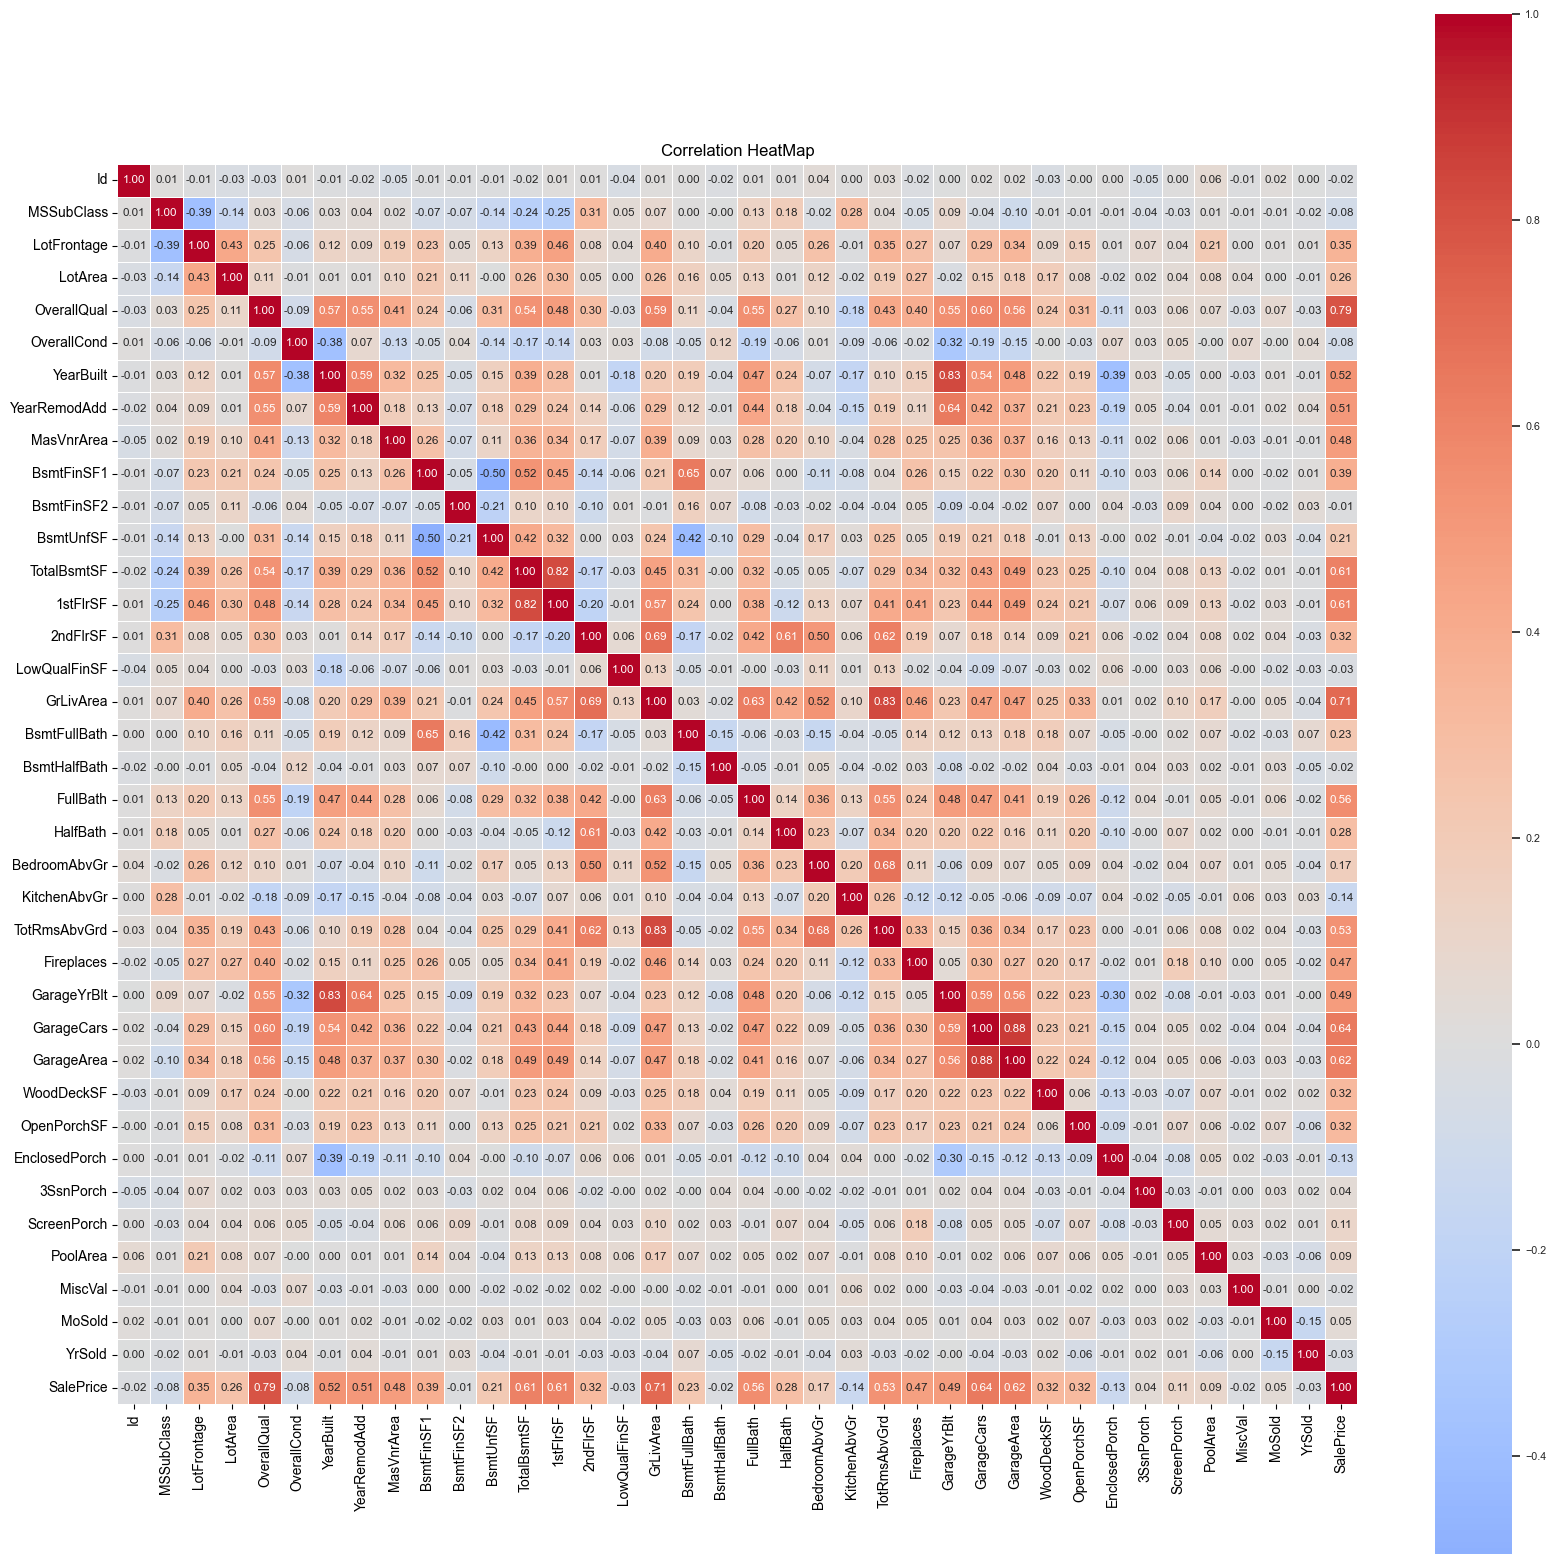

In [53]:
show_correlation_map(train_df)

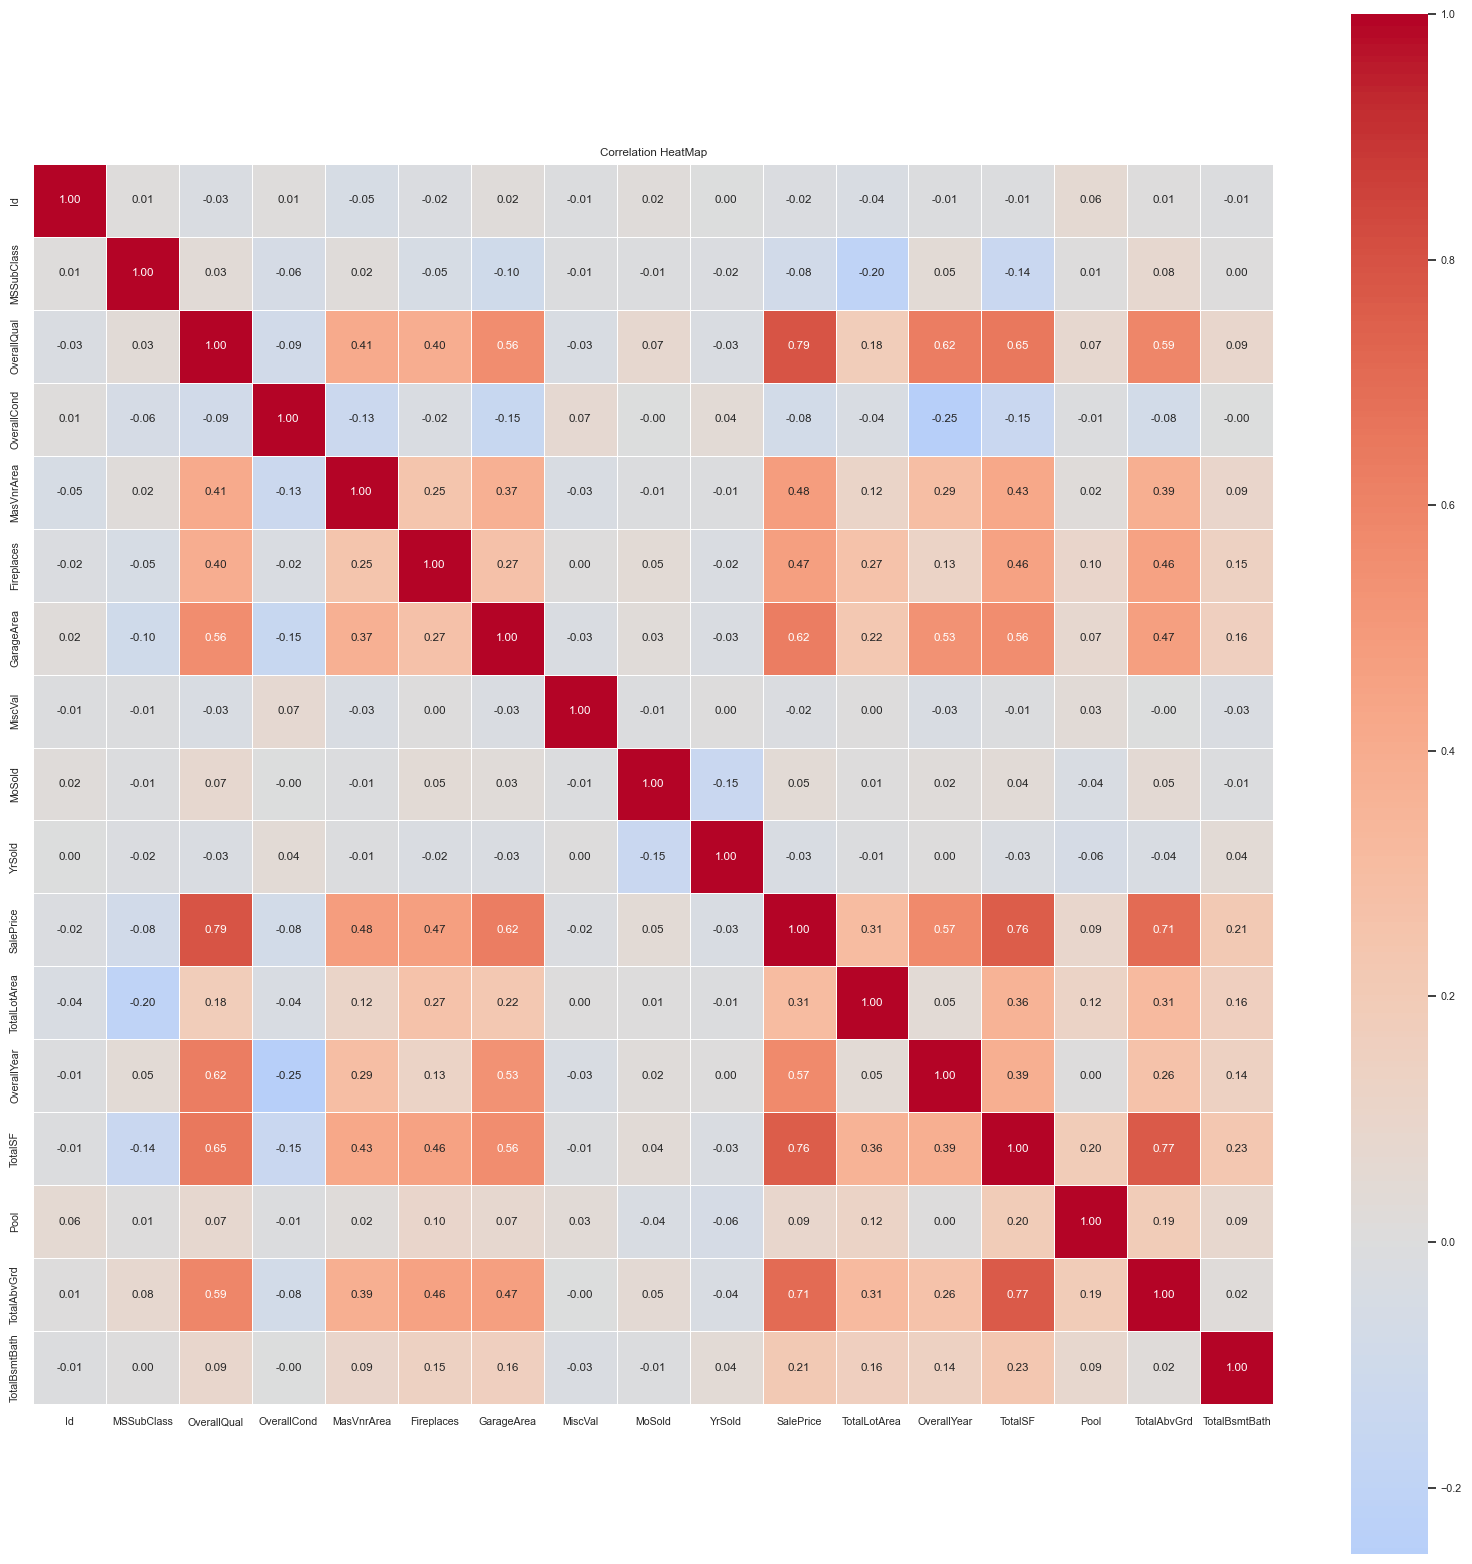

In [54]:
train_dataset = train_df.copy()

# LotArea and LotFrantage
train_dataset.loc[:, 'TotalLotArea'] = train_dataset.loc[:, 'LotArea'] + train_dataset.loc[:, 'LotFrontage']

# YearBuilt, YearRemodAdd, GarageYrBlt
train_dataset.loc[:, 'OverallYear'] = train_dataset.loc[:, ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].mean(axis=1).astype(int)

# BsmtFinSF1	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF	1stFlrSF	2ndFlrSF	LowQualFinSF	WoodDeckSF	OpenPorchSF
train_dataset.loc[:, 'TotalSF'] = train_dataset.loc[:, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',	'1stFlrSF',	
    '2ndFlrSF',	'LowQualFinSF',	'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)

# pool area
train_dataset.loc[:, 'Pool'] = train_dataset.loc[:, 'PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# total above
train_dataset.loc[:, 'TotalAbvGrd'] = train_dataset.loc[:, ['GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']].sum(axis=1)

# BsmtFullBath, BsmtHalfBath
train_dataset.loc[:, 'TotalBsmtBath'] = train_dataset.loc[:, ['BsmtFullBath', 'BsmtHalfBath']].sum(axis=1)


train_dataset = train_dataset.drop(columns=[
    'LotArea', 'LotFrontage', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
    'BsmtFinSF1', 'BsmtFinSF2',	'BsmtUnfSF', 'TotalBsmtSF',	'1stFlrSF',	
    '2ndFlrSF',	'LowQualFinSF',	'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'FullBath', 'HalfBath', 'GarageCars', 'PoolArea',
    'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'BsmtFullBath', 'BsmtHalfBath'
])

show_correlation_map(train_dataset)

In [ ]:
train_df['2ndFlrSF']

0        854
1          0
2        866
3        756
4       1053
        ... 
1455     694
1456       0
1457    1152
1458       0
1459       0
Name: 2ndFlrSF, Length: 1460, dtype: int64

In [ ]:
train.LotFrontage

NameError: name 'train' is not defined

In [ ]:
train_dataset.loc[:, ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']]

KeyError: "None of [Index(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], dtype='object')] are in the [columns]"

<Axes: >

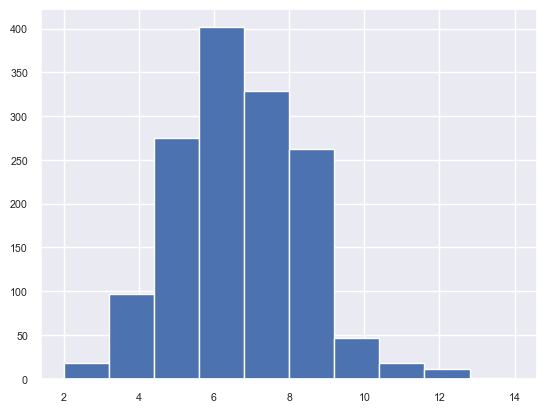

In [ ]:
train_df['TotRmsAbvGrd'].hist()

<Axes: >

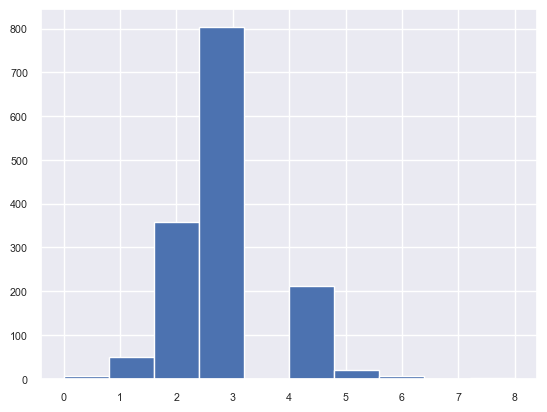

In [ ]:
train_df['BedroomAbvGr'].hist()

<Axes: >

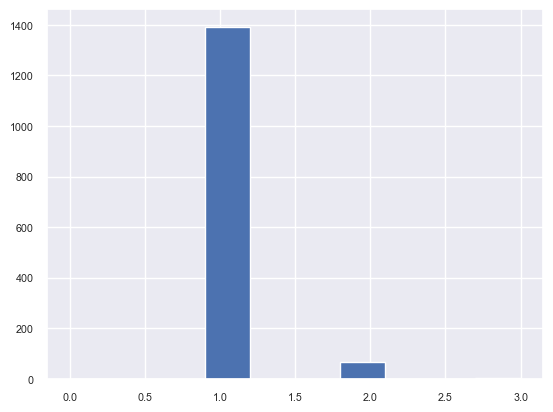

In [ ]:
train_df['KitchenAbvGr'].hist()

In [ ]:
train_df[['FullBath', 'HalfBath']]

,FullBath,HalfBath
0,2,1
1,2,0
2,2,1
3,1,0
4,2,1
...,...,...
1455,2,1
1456,2,0
1457,2,0
1458,1,0
